2025-04-09 20:03:00,251 - INFO - Reading CSV from S3 path: s3://sagemaker-us-east-2-426179662034/canvas/processed/facility_merge_processed.csv
2025-04-09 20:03:00,327 - INFO - Initializing a Ray instance
2025-04-09 20:03:01,989	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 904900608 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=2.01gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-04-09 20:03:03,270	INFO worker.py:1786 -- Started a local Ray instance.
/opt/conda/lib/python3.11/site-packages/awswrangler/s3/_read_text_core.py:115: DtypeWarning: Columns (1,5,6,10,11,13,14,16,20,22,25,27,29,32,33,36,37,38,44,45,50,56,62,65,67,71,76,78,81,83,86,87,92,95) have mixed types. Specify 

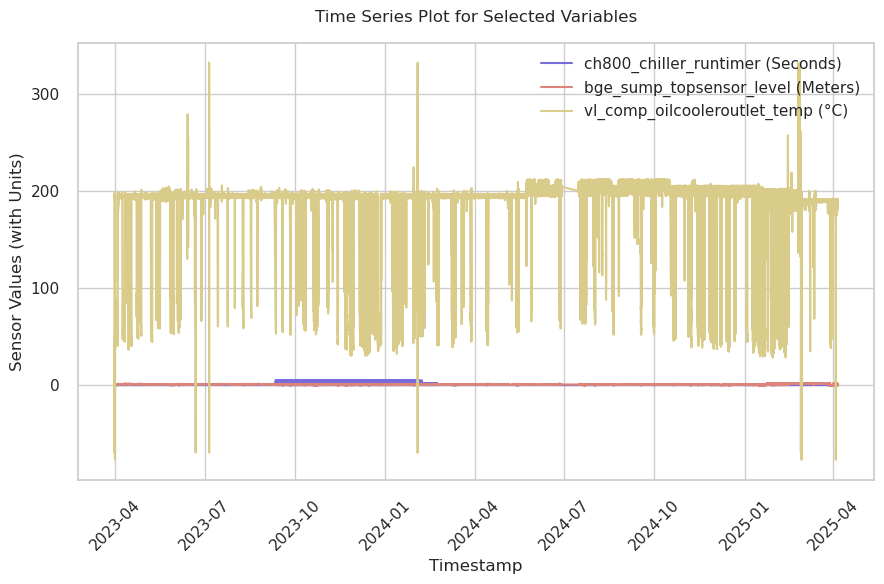

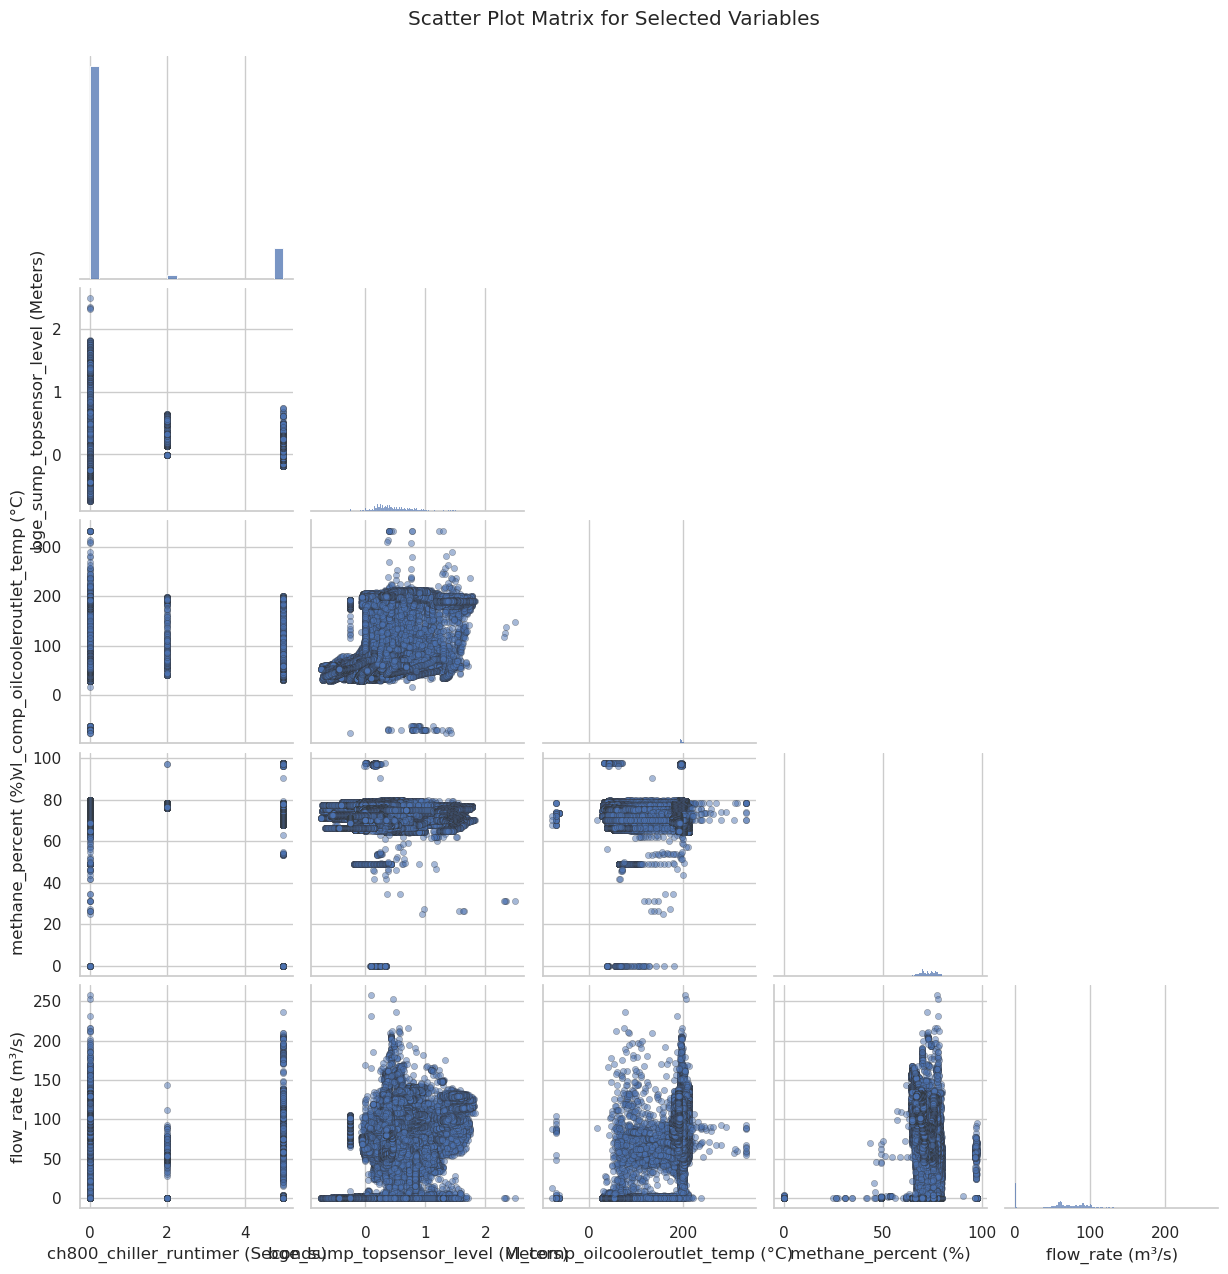

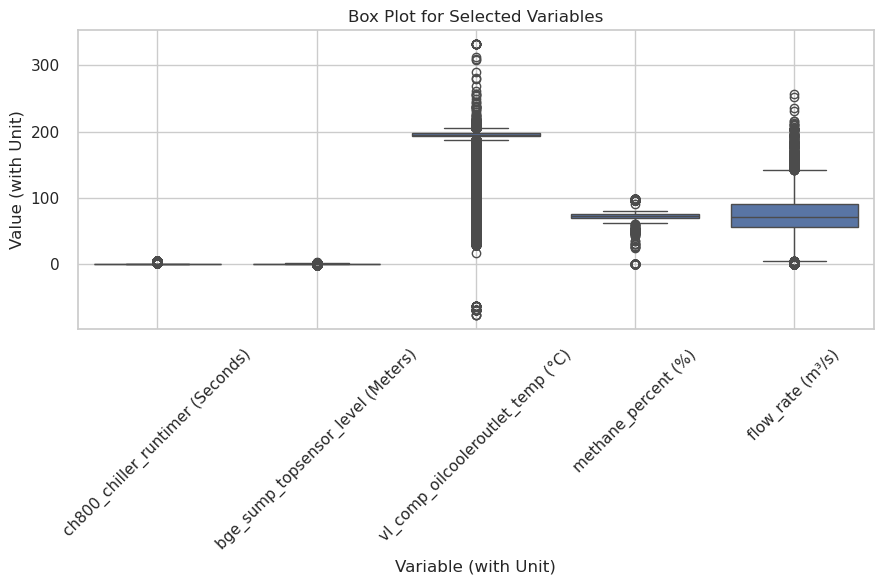

/tmp/ipykernel_11412/2361845900.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='operational', y=variable, data=df, palette='muted', ax=ax)


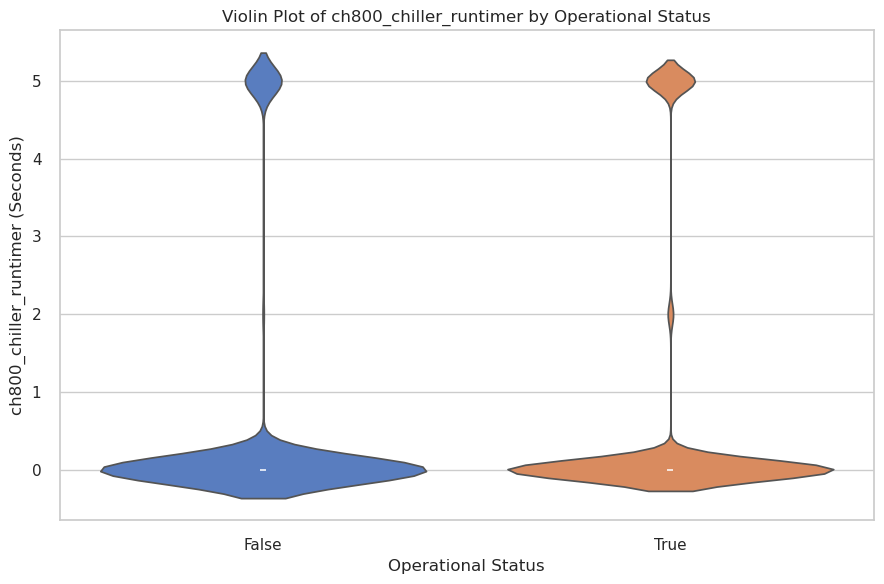

KeyboardInterrupt: 

*** SIGTERM received at time=1744229096 on cpu 0 ***
PC: @     0x557dd4c32c83  (unknown)  _Py_dict_lookup
    @     0x7f82cf61d4fd         64  absl::lts_20230802::AbslFailureSignalHandler()
    @     0x7f8324263520  (unknown)  (unknown)
    @            0x10606  (unknown)  (unknown)
[2025-04-09 20:04:56,502 E 11412 11412] logging.cc:440: *** SIGTERM received at time=1744229096 on cpu 0 ***
[2025-04-09 20:04:56,502 E 11412 11412] logging.cc:440: PC: @     0x557dd4c32c83  (unknown)  _Py_dict_lookup
[2025-04-09 20:04:56,508 E 11412 11412] logging.cc:440:     @     0x7f82cf61d529         64  absl::lts_20230802::AbslFailureSignalHandler()
[2025-04-09 20:04:56,508 E 11412 11412] logging.cc:440:     @     0x7f8324263520  (unknown)  (unknown)
[2025-04-09 20:04:56,512 E 11412 11412] logging.cc:440:     @            0x10606  (unknown)  (unknown)


In [ ]:
# Imports and logger setup
import awswrangler as wr
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
#from matplotlib.dates import DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import parallel_coordinates

# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Global styles
plt.style.use('seaborn-v0_8')
sns.set(style='whitegrid')


#  S3 reader function
def read_csv_from_s3(s3_path: str) -> pd.DataFrame:
    logger.info(f"Reading CSV from S3 path: {s3_path}")
    return wr.s3.read_csv(s3_path)


# Preprocessing
def prepare_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df = df.sort_values('timestamp')
    return df


# Time series plot
def plot_time_series_multivariate(df, columns, units):
    fig, ax = plt.subplots(figsize=(9, 6))
    colors = ['#766CDB', '#DA847C', '#D9CC8B', '#7CD9A5']

    for i, col in enumerate(columns):
        if col in df.columns:
            ax.plot(df['timestamp'], df[col], label=f"{col} ({units.get(col, '')})", color=colors[i % len(colors)])

    ax.set_title('Time Series Plot for Selected Variables', pad=15)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Sensor Values (with Units)')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Scatter matrix
def plot_pairwise_scatter_matrix(df, cols, units):
    cols = [c for c in cols if c in df.columns]
    df_subset = df[cols].dropna().copy()
    df_subset.rename(columns={c: f"{c} ({units.get(c, '')})" for c in cols}, inplace=True)
    sns.pairplot(df_subset, corner=True, plot_kws={'alpha':0.5, 's':20, 'edgecolor':'#333333'})
    plt.suptitle('Scatter Plot Matrix for Selected Variables', y=1.02)
    plt.show()


# Box plot
def plot_boxplots(df, cols, units):
    cols = [c for c in cols if c in df.columns]
    melted = df[cols].melt(var_name='Variable', value_name='Value')
    melted['Unit'] = melted['Variable'].apply(lambda x: units.get(x, ''))
    melted['Variable'] = melted['Variable'].apply(lambda x: f"{x} ({units.get(x, '')})")
    fig, ax = plt.subplots(figsize=(9, 6))
    sns.boxplot(x='Variable', y='Value', data=melted, ax=ax)
    ax.set_title('Box Plot for Selected Variables')
    ax.set_xlabel('Variable (with Unit)')
    ax.set_ylabel('Value (with Unit)')
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Violin plot
def plot_violin_operational(df, variable, unit):
    if 'operational' in df.columns and variable in df.columns:
        fig, ax = plt.subplots(figsize=(9, 6))
        sns.violinplot(x='operational', y=variable, data=df, palette='muted', ax=ax)
        ax.set_title(f'Violin Plot of {variable} by Operational Status')
        ax.set_ylabel(f'{variable} ({unit})')
        ax.set_xlabel('Operational Status')
        plt.tight_layout()
        plt.show()


# Parallel Coordinates
def plot_parallel_coordinates_by_operational(df, cols):
    cols = [c for c in cols if c in df.columns]
    if 'operational' in df.columns and len(cols) > 1:
        df_plot = df[cols + ['operational']].dropna()
        df_plot['operational'] = df_plot['operational'].astype(str)
        parallel_coordinates(df_plot, 'operational', color=['#766CDB', '#DA847C'])
        plt.title('Parallel Coordinates Plot by Operational Status')
        plt.ylabel('Scaled Value (varies by metric)')
        plt.tight_layout()
        plt.show()


# Correlation heatmaps
def plot_correlation_by_status(df, metrics):
    operational = df[df['operational'] == True][metrics].corr()
    non_operational = df[df['operational'] == False][metrics].corr()
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    sns.heatmap(operational, annot=True, cmap='coolwarm', ax=axes[0], vmin=-1, vmax=1)
    axes[0].set_title('Operational Correlation')
    axes[0].set_ylabel('')
    axes[0].set_xlabel('')
    sns.heatmap(non_operational, annot=True, cmap='coolwarm', ax=axes[1], vmin=-1, vmax=1)
    axes[1].set_title('Non-Operational Correlation')
    axes[1].set_ylabel('')
    axes[1].set_xlabel('')
    plt.tight_layout()
    plt.show()


# Seasonal decomposition - Multivariate
def plot_seasonal_decomposition(df, variable, freq=7):
    ts = df.set_index('timestamp')[variable].resample('D').mean().interpolate()
    if len(ts.dropna()) >= freq * 2:
        result = seasonal_decompose(ts, model='additive', period=freq)
        result.plot()
        plt.suptitle(f'Seasonal Decomposition of {variable}', fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        logger.warning(f"Not enough data to decompose {variable}. Require at least {freq*2} points.")


# Summary statistics
def summarize_by_operational_status(df, metrics, units):
    summary = df.groupby('operational')[metrics].agg(['mean', 'std', 'min', 'max']).round(2)
    formatted = pd.DataFrame()
    formatted['Operational Status'] = ['Operational' if x else 'Non-Operational' for x in summary.index]
    for metric in metrics:
        unit = units.get(metric, '')
        for stat in ['mean', 'std', 'min', 'max']:
            colname = f"{metric} {stat.title()} ({unit})"
            formatted[colname] = summary[(metric, stat)].values
    logger.info("Summary statistics computed.")
    return formatted


if __name__ == "__main__":
    s3_path = 's3://sagemaker-us-east-2-426179662034/canvas/processed/facility_merge_processed.csv'
    df = prepare_dataframe(read_csv_from_s3(s3_path))

    units = {
        'ch800_chiller_runtimer': 'Seconds',
        'bge_sump_topsensor_level': 'Meters',
        'vl_comp_oilcooleroutlet_temp': '°C',
        'methane_percent': '%',
        'flow_rate': 'm³/s'
    }

    metrics = list(units.keys())

    plot_time_series_multivariate(df, metrics[:3], units)
    plot_pairwise_scatter_matrix(df, metrics, units)
    plot_boxplots(df, metrics, units)
    plot_violin_operational(df, 'ch800_chiller_runtimer', units['ch800_chiller_runtimer'])
    plot_parallel_coordinates_by_operational(df, metrics[:-1])
    plot_correlation_by_status(df, metrics)
    plot_seasonal_decomposition(df, 'ch800_chiller_runtimer', freq=7)
    formatted = summarize_by_operational_status(df, metrics, units)
    logger.info("Summary statistics are: ", formatted)

    ################# Summary: ##############################

    # A time series plot was produced for three key continuous variables:
    # ch800_chiller_runtimer
    # bge_sump_topsensor_level
    # vl_comp_oilcooleroutlet_temp
    # These plots help visualize how these measurements change over time.

    # To study multivariate relationships, a scatter plot (pairplot) was generated for a subset of variables including:
    # ch800_chiller_runtimer
    # bge_sump_topsensor_level
    # vl_comp_oilcooleroutlet_temp
    # methane_percent
    # flow_rate
    # This allows us to examine pairwise relationships and potential correlations between these variables.

    # Box plots were drawn for the same set of selected continuous variables to better understand the distributions, outliers, and spread of each measurement.
    # The multivariate visualizations (both the scatter plot matrix and box plots) allow us to inspect the relationships across sensors and evaluate the consistency and spread of the measurement variables. These insights can be used to investigate measurement behavior, flag anomalies, or prepare for further statistical modeling.

    # Correlation Heatmap:This visualization shows the correlation coefficients between selected continuous variables. The color intensity and value indicate how variables are related to one another. Strong positive correlations appear in dark red, while strong negative correlations appear in dark blue.                                                                       
    # The heatmap reveals the strength and direction of relationships between variables like chiller runtime, sump level, temperature, and methane percentage.

    # Violin Plot: This plot compares the distribution of chiller runtime grouped by operational status. Violin plots combine aspects of box plots and kernel density plots to show the full distribution of data.
    # The violin plot helps visualize how chiller runtime varies based on whether the system is operational or not, showing both the central tendency and the spread of values.

    # Parallel Coordinates Plot: This visualization technique is excellent for comparing multiple variables across different categories. Each vertical line represents a variable, and each colored line passing through them represents an observation, grouped by operational status.
    # The parallel coordinates plot allows us to see patterns across multiple dimensions simultaneously, making it easier to identify clusters or groups in the data based on operational status.

    # These additional multivariate visualizations complement our earlier analysis by revealing relationships between variables and how they vary across different operational states. The correlation heatmap shows the strength of relationships, the violin plot reveals distribution differences, and the parallel coordinates plot helps identify patterns across multiple dimensions.

    # Daily Average Time series: This plot shows the daily average values for key variables over time. You can observe:
    # Long-term trends across the two-year period
    # Seasonal fluctuations that repeat at regular intervals
    # The relationship between different variables as they change over time

    # Weekly Patterns (Day of Week Analysis): This visualization breaks down each variable by day of the week (0=Monday through 6=Sunday), revealing:
    # Weekly cyclical patterns in facility operations
    # Different operational behaviors on weekdays versus weekends
    # Consistent patterns that might indicate scheduled maintenance or operational procedures

    # Hourly Patterns (Time of Day Analysis): The hourly pattern analysis shows how variables change throughout a typical 24-hour day:
    # Daily operational cycles
    # Peak usage or activity periods
    # Overnight vs. daytime operational differences

    # Seasonal Decomposition : This advanced analysis breaks down the chiller runtime variable into its components:
    # Observed - The original time series data
    # Trend - The long-term progression (increasing or decreasing over time)
    # Seasonal - The repeating patterns at regular intervals (weekly in this case)
    # Residual - The random variation that remains after accounting for trend and seasonality
    # The seasonal component clearly shows the cyclical pattern that repeats weekly, while the trend component reveals the long-term direction of the variable over the two-year period.

    # These visualizations provide valuable insights into the facility's operational patterns, helping to identify:
    # Regular maintenance schedules
    # Operational efficiency cycles
    # Potential areas for optimization based on time-of-day or day-of-week patterns
    # Long-term trends that might indicate equipment aging or seasonal environmental effects

    # The code displays:
    # A univariate analysis (KDE and box plots) for each metric by operational status and across facilities with labels that include their respective units.
    # A multivariate analysis (scatter plots and correlation heatmaps) showing relationships between metrics with units.
    # A facility performance comparison using a facet grid (catplot) where each metric includes its unit.
    # A time series analysis for selected metrics with the date on the x-axis.
    # A summary statistics table grouped by operational status with units added to each column header.

    # Below are the outputs:
    # For the printed list of metrics with the corresponding units, please see:
    # Selected metrics for analysis with units:
    # ch800_chiller_runtimer: Hours
    # bge_sump_topsensor_level: Feet
    # vl_comp_oilcooleroutlet_temp: °F
    # methane_percent: %
    # flow_rate: SCFM
    # energy_output_btu: BTU
